In [ ]:
# adapted from  Sasank Chilamkurthy but for cats classification 

In [15]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
%cd "drive/My Drive/PY580/cats"

[Errno 2] No such file or directory: 'drive/My Drive/PY580/cats'
/content/drive/My Drive/PY580/cats


In [17]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print(os.getcwd())

/content/drive/My Drive/PY580/cats


In [18]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [20]:
dir_data = os.getcwd()

image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

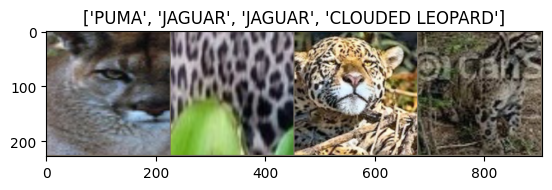

In [21]:
#check the images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [22]:
def train_model(model, loss_CEL, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_CEL(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [24]:
# load pretrianed model and load up to the final layer

pretrained_model = models.resnet18(pretrained=True)
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)

pretrained_model = pretrained_model.to(device)

loss = nn.CrossEntropyLoss()
optimizer_model = optim.SGD(pretrained_model.parameters(), lr=0.0001) 


In [30]:
model_retrain = train_model(pretrained_model, loss,optimizer_model,num_epochs=10 )

Epoch 0/9
----------
train Loss: 2.0053 Acc: 0.3523
valid Loss: 1.6591 Acc: 0.5200

Epoch 1/9
----------
train Loss: 1.8888 Acc: 0.4177
valid Loss: 1.5195 Acc: 0.5400

Epoch 2/9
----------
train Loss: 1.7949 Acc: 0.4690
valid Loss: 1.3736 Acc: 0.5600

Epoch 3/9
----------
train Loss: 1.7051 Acc: 0.5130
valid Loss: 1.2539 Acc: 0.5800

Epoch 4/9
----------
train Loss: 1.6340 Acc: 0.5250
valid Loss: 1.1136 Acc: 0.6800

Epoch 5/9
----------
train Loss: 1.5453 Acc: 0.5678
valid Loss: 1.0333 Acc: 0.7400

Epoch 6/9
----------
train Loss: 1.4912 Acc: 0.5802
valid Loss: 0.9227 Acc: 0.7600

Epoch 7/9
----------
train Loss: 1.4307 Acc: 0.5904
valid Loss: 0.8759 Acc: 0.7200

Epoch 8/9
----------
train Loss: 1.3701 Acc: 0.6007
valid Loss: 0.8264 Acc: 0.7400

Epoch 9/9
----------
train Loss: 1.3155 Acc: 0.6233
valid Loss: 0.7232 Acc: 0.7800

Training complete in 3m 7s
Best val Acc: 0.780000


In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

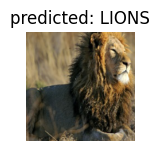

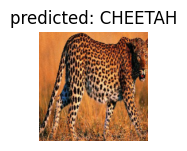

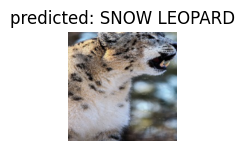

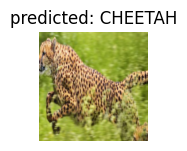

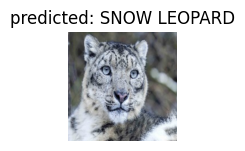

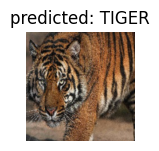

In [29]:
visualize_model(model_retrain)